<a href="https://colab.research.google.com/github/lauraosede/CE888/blob/main/Lab_4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)


#### Load dataset

Load the data from ``jester-data-1.csv'',
The data is from http://eigentaste.berkeley.edu/dataset/ and it contains the ratings of 100 jokes from 11,190 users
* Check the dataset description to figure out which value you should replace with NaNs (the cells for which we don't have a rating). This is the test set.
To replace values when you load, you can find help here: https://stackoverflow.com/questions/29247712/how-to-replace-a-value-in-pandas-with-nan
* There's a column you need to remove because it doesn't contain ratings. Check the description of the dataset and figure out which one. Then drop it.

In [3]:
dataset = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', delimiter= ',' ,  header=None)

In [4]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [5]:
#change the name of first column to reprsent number of jokes rated
column_indices = [0]
new_names = ['number_of_jokes_rated']
old_names = dataset.columns[column_indices]
dataset.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [6]:
#drop columns that don't contain ratings
#22 of the jokes don't have ratings, their ids are: {1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 14, 20, 27, 31, 43, 51, 52, 61, 73, 80, 100, 116}.
column_indices = [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 14, 20, 27, 31, 43, 51, 52, 61, 73, 80, 100]
dataset = dataset.drop(column_indices,  axis = 1)

In [7]:
dataset.head()

,number_of_jokes_rated,7,8,13,15,16,17,18,19,21,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,53,54,55,56,57,58,59,60,62,63,64,65,66,67,68,69,70,71,72,74,75,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,74,-9.85,4.17,-7.18,-7.18,-7.52,-7.43,-9.81,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,2.86,9.13,-7.43,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,-8.11,-9.13,-9.08,-7.14,-6.26,3.79,-0.10,3.93,4.13,3.20,8.30,-4.56,0.92,-9.13,-9.42,2.82,-8.64,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00
1,100,-0.73,-5.34,4.42,4.56,-0.97,4.66,-0.68,3.30,0.87,8.64,8.35,9.17,0.05,7.57,0.87,-0.39,6.99,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,7.82,-3.83,8.98,-4.32,-3.20,-4.90,-0.92,-1.46,3.64,0.97,-1.31,-6.50,-3.20,8.64,-2.14,0.10,9.03,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,7.77,7.33,6.21,7.72,8.98,8.64,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32
2,49,9.03,9.27,9.37,-6.36,-6.89,-7.86,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,8.93,99.00,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,7.52,9.27,99.00,9.27,99.00,6.17,7.33,9.08,7.28,7.28,7.33,99.00,7.23,99.00,99.00,99.00,9.27,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.00,99.00,8.93,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00
3,48,-2.82,6.21,6.31,-7.23,-6.65,1.17,-6.60,-3.64,5.34,99.00,99.00,99.00,99.00,2.91,6.75,6.60,99.00,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,99.00,1.55,99.00,99.00,6.84,6.84,-3.98,6.99,3.45,1.55,7.67,99.00,6.55,99.00,99.00,99.00,99.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00
4,91,7.04,4.61,-3.93,-2.33,-9.66,2.72,-1.36,2.57,8.20,6.12,8.30,-1.26,7.77,1.89,5.68,8.45,4.61,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,0.34,6.84,-8.74,5.24,6.31,8.06,1.26,4.51,-0.05,8.93,7.82,1.75,8.11,-8.06,-9.17,4.95,3.35,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.00,99.00,99.00,4.13,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80


In [8]:
dataset.shape

(24983, 80)

Check the dataset description to figure out which value you should replace with NaNs (the cells for which we don't have a rating). This is the test set.

In [9]:
# We will be using small set of data to monitor each step and later create a method 
# r_df is subset of rating_df ! here we will only take 10 users and 8 jokes
r_df = dataset.iloc[0:10, 0:10]
r_df.head()

,number_of_jokes_rated,7,8,13,15,16,17,18,19,21
0,74,-9.85,4.17,-7.18,-7.18,-7.52,-7.43,-9.81,-9.85,-9.37
1,100,-0.73,-5.34,4.42,4.56,-0.97,4.66,-0.68,3.30,0.87
2,49,9.03,9.27,9.37,-6.36,-6.89,-7.86,9.03,9.03,7.28
3,48,-2.82,6.21,6.31,-7.23,-6.65,1.17,-6.60,-3.64,5.34
4,91,7.04,4.61,-3.93,-2.33,-9.66,2.72,-1.36,2.57,8.20


In [10]:
# Since 99 represents null value, We will replace it with blank for joke_1 column
r_df[7] = r_df[7].replace([99],np.nan)
r_df

,number_of_jokes_rated,7,8,13,15,16,17,18,19,21
0,74,-9.85,4.17,-7.18,-7.18,-7.52,-7.43,-9.81,-9.85,-9.37
1,100,-0.73,-5.34,4.42,4.56,-0.97,4.66,-0.68,3.30,0.87
2,49,9.03,9.27,9.37,-6.36,-6.89,-7.86,9.03,9.03,7.28
3,48,-2.82,6.21,6.31,-7.23,-6.65,1.17,-6.60,-3.64,5.34
4,91,7.04,4.61,-3.93,-2.33,-9.66,2.72,-1.36,2.57,8.20
5,100,-8.69,-0.87,-5.00,0.49,-8.93,-3.69,-2.18,-2.28,-3.01
6,47,7.72,8.79,-6.26,6.07,-3.50,-2.09,6.17,5.15,5.63
7,100,9.27,1.41,-6.94,0.29,-9.90,-7.09,-7.18,1.02,-4.71
8,100,-5.29,-8.93,-4.85,-8.74,-6.99,-8.74,-2.91,-3.35,3.98
9,72,8.93,2.52,4.47,-4.66,-0.97,-0.44,1.55,0.49,5.44


In [11]:
r_df.iloc[1, 2:] - np.mean(r_df.iloc[1, 2:])

8    -6.6925
13    3.0675
15    3.2075
16   -2.3225
17    3.3075
18   -2.0325
19    1.9475
21   -0.4825
Name: 1, dtype: float64

In [12]:
# Selecting all joke columns
joke_columns = r_df.columns[2:] # joke column starts from second column
joke_columns

Index([8, 13, 15, 16, 17, 18, 19, 21], dtype='object')

In [13]:
# replacing 99 with nan value
def replace_99(ratings):
    '''
    Replace 99 with nan for user's rating value
    step 1: select joke columns
    step 2: replace 99 with np.nan for all columns
    
    '''
    joke_ids = ratings.columns[2:]    
    for joke_id in joke_ids: 
        ratings[joke_id] = ratings[joke_id].replace([99],np.nan)
    return ratings

# Now creating a function that takes all the raw data as input and complete step 1 
def normalization(ratings):
    ''' 
    Returns mean subtracted user's rating value
    step 1: subtract user's rating by their mean value for each row 
    '''
    total_users = ratings.shape[0]
    for i in range(total_users):
        ratings.iloc[i, 2:] = ratings.iloc[i, 2:] - np.mean(ratings.iloc[i, 2:])
    return ratings

# replacing nan with 0
def replace_0(ratings):
    '''
    Replace nan with 0 for user's rating value
    step 1: select joke columns
    step 2: replace np.nan with 0 for all columns
    
    '''
    joke_ids = ratings.columns[2:]    
    for joke_id in joke_ids: 
        ratings[joke_id] = ratings[joke_id].replace([np.nan],0)
    return ratings

In [14]:
## Here Spark will be better choce that
temp1 = replace_99(r_df)
temp2 = normalization(temp1)
temp3 = replace_0(temp2)
temp3.head()

,number_of_jokes_rated,7,8,13,15,16,17,18,19,21
0,74,-9.85,10.94125,-0.40875,-0.40875,-0.74875,-0.65875,-3.03875,-3.07875,-2.59875
1,100,-0.73,-6.69250,3.06750,3.20750,-2.32250,3.30750,-2.03250,1.94750,-0.48250
2,49,9.03,6.41125,6.51125,-9.21875,-9.74875,-10.71875,6.17125,6.17125,4.42125
3,48,-2.82,6.84625,6.94625,-6.59375,-6.01375,1.80625,-5.96375,-3.00375,5.97625
4,91,7.04,4.50750,-4.03250,-2.43250,-9.76250,2.61750,-1.46250,2.46750,8.09750


In [15]:
# we will normalize and save into normalized_ratings dataframe!
normalized_ratings = replace_99(dataset)
normalized_ratings = normalization(normalized_ratings)
normalized_ratings = replace_0(normalized_ratings)
normalized_ratings.head()

,number_of_jokes_rated,7,8,13,15,16,17,18,19,21,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,53,54,55,56,57,58,59,60,62,63,64,65,66,67,68,69,70,71,72,74,75,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,74,-9.85,7.343455,-4.006545,-4.006545,-4.346545,-4.256545,-6.636545,-6.676545,-6.196545,4.673455,-1.196545,-6.636545,-5.326545,4.293455,6.033455,12.303455,-4.256545,-0.906545,-5.906545,10.993455,8.223455,8.123455,-5.996545,-5.226545,-5.226545,-5.226545,-4.936545,-5.956545,-5.906545,-3.966545,-3.086545,6.963455,3.073455,7.103455,7.303455,6.373455,11.473455,-1.386545,4.093455,-5.956545,-6.246545,5.993455,-5.466545,6.763455,-3.666545,-5.856545,5.993455,1.813455,-5.906545,11.473455,8.853455,-1.636545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.246545,0.000000,0.000000,-4.546545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.993455,0.000000,0.000000,0.000000,0.000000,0.000000,-2.456545,0.000000,0.000000
1,100,-0.73,-7.779231,1.980769,2.120769,-3.409231,2.220769,-3.119231,0.860769,-1.569231,6.200769,5.910769,6.730769,-2.389231,5.130769,-1.569231,-2.829231,4.550769,-3.359231,4.700769,6.590769,-4.239231,-1.709231,4.650769,0.960769,-3.309231,5.470769,5.380769,-6.269231,6.540769,-6.759231,-5.639231,-7.339231,-3.359231,-3.899231,1.200769,-1.469231,-3.749231,-8.939231,-5.639231,6.200769,-4.579231,-2.339231,6.590769,-5.789231,-11.469231,2.030769,1.640769,-6.269231,6.300769,-1.319231,-1.659231,5.080769,-7.439231,0.330769,5.330769,4.890769,3.770769,5.280769,6.540769,6.200769,1.490769,2.410769,2.410769,3.630769,6.540769,2.070769,-2.489231,1.250769,2.120769,-1.859231,0.380769,-7.389231,-2.729231,5.420769,-2.629231,-4.579231,0.620769,-2.099231,-6.759231
2,49,9.03,2.454324,2.554324,-13.175676,-13.705676,-14.675676,2.214324,2.214324,0.464324,0.000000,1.434324,0.000000,0.000000,0.664324,0.464324,2.114324,0.000000,0.464324,0.000000,0.000000,2.164324,0.514324,0.000000,-0.645676,2.264324,0.514324,0.704324,2.454324,0.000000,2.454324,0.000000,-0.645676,0.514324,2.264324,0.464324,0.464324,0.514324,0.000000,0.414324,0.000000,0.000000,0.000000,2.454324,0.464324,0.000000,0.000000,0.224324,0.464324,0.000000,0.464324,1.434324,0.000000,0.000000,0.000000,0.000000,0.000000,2.114324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.214324,0.000000,0.000000,0.000000,2.264324,0.000000,0.000000,0.000000,0.000000,0.000000
3,48,-2.82,4.130286,4.230286,-9.309714,-8.729714,-0.909714,-8.679714,-5.719714,3.260286,0.000000,0.000000,0.000000,0.000000,0.830286,4.670286,4.520286,0.000000,-8.199714,0.000000,5.490286,4.130286,4.570286,0.000000,-10.379714,5.100286,0.740286,0.000000,-0.529714,0.000000,0.000000,4.760286,4.760286,-6.059714,4.910286,1.370286,-0.529714,5.590286,0.000000,4.470286,0.000000,0.000000,0.000000,0.000000,-5.769714,0.000000,0.000000,5.740286,-1.839714,0.000000,5.200286,-4.409714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.449714,0.000000,0.000000,-4.409714,0.000000,0.000000,0.000000,0.000000,0.000000,-1.549714,0.000000,0.000000,0.000000,0.000000,0.000000
4,91,7.04,1.415915,-7.124085,-5.524085,-12.854085,-0.474085,-4.554085,-0.624085,5.005915,2.925915,5.105915,-4.454085,4.575915,-1.304085,2.485915,5.255915,1.415915,-12.664085,4.085915,2.485915,-0.714085,0.005915,-4.454085,3.605915,1.315915,-0.714085,-2.854085,3.645915,-11.934085,2.045915,3.115915,4.865915,-1.934085,1.315915,-3.244085,5.735915,4.625915,-1.444085,4.915915,-11.254085,-12.364085,1.755915,0.155915,2.975915,1.515915,-5.474085,4.185915,1.365915,3.945915,1.025915,-0.184085,0.635915,0.000000,0.000000,0.000000,0.000000,0.000000,0.935915,0.000000,0.000000,2.045915,2.725915,-2.324085,4.085915,0.735915,-3.824085,3.115915,1.515915,-0.374085,-0.234085,1.995915,2.385915,1.075915,1.995915,2.535915,-1.644085,-0.084085,3.355915,-1.394085


In [16]:
normalized_ratings.isnull().sum()

number_of_jokes_rated    0
7                        0
8                        0
13                       0
15                       0
                        ..
95                       0
96                       0
97                       0
98                       0
99                       0
Length: 80, dtype: int64

#### Building a joke recommender system using latent factor modeling for collaborative filtering
* joke analysis for best rated and worst rated joke
* Use pandas to find the best- and the worst-rated jokes

since each joke is rated from -10 to +10 with -10 being the worst and +10 being the best and 99 being a null rating, we will:
* set the null rating to zero.
* sum each joke in our data frame
*filter the top and the lowest

In [17]:
best_worst_jk = normalized_ratings.replace(to_replace=99.000000, value=0)

In [18]:
best_worst_jk.head()

,number_of_jokes_rated,7,8,13,15,16,17,18,19,21,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,53,54,55,56,57,58,59,60,62,63,64,65,66,67,68,69,70,71,72,74,75,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,74,-9.85,7.343455,-4.006545,-4.006545,-4.346545,-4.256545,-6.636545,-6.676545,-6.196545,4.673455,-1.196545,-6.636545,-5.326545,4.293455,6.033455,12.303455,-4.256545,-0.906545,-5.906545,10.993455,8.223455,8.123455,-5.996545,-5.226545,-5.226545,-5.226545,-4.936545,-5.956545,-5.906545,-3.966545,-3.086545,6.963455,3.073455,7.103455,7.303455,6.373455,11.473455,-1.386545,4.093455,-5.956545,-6.246545,5.993455,-5.466545,6.763455,-3.666545,-5.856545,5.993455,1.813455,-5.906545,11.473455,8.853455,-1.636545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.246545,0.000000,0.000000,-4.546545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.993455,0.000000,0.000000,0.000000,0.000000,0.000000,-2.456545,0.000000,0.000000
1,100,-0.73,-7.779231,1.980769,2.120769,-3.409231,2.220769,-3.119231,0.860769,-1.569231,6.200769,5.910769,6.730769,-2.389231,5.130769,-1.569231,-2.829231,4.550769,-3.359231,4.700769,6.590769,-4.239231,-1.709231,4.650769,0.960769,-3.309231,5.470769,5.380769,-6.269231,6.540769,-6.759231,-5.639231,-7.339231,-3.359231,-3.899231,1.200769,-1.469231,-3.749231,-8.939231,-5.639231,6.200769,-4.579231,-2.339231,6.590769,-5.789231,-11.469231,2.030769,1.640769,-6.269231,6.300769,-1.319231,-1.659231,5.080769,-7.439231,0.330769,5.330769,4.890769,3.770769,5.280769,6.540769,6.200769,1.490769,2.410769,2.410769,3.630769,6.540769,2.070769,-2.489231,1.250769,2.120769,-1.859231,0.380769,-7.389231,-2.729231,5.420769,-2.629231,-4.579231,0.620769,-2.099231,-6.759231
2,49,9.03,2.454324,2.554324,-13.175676,-13.705676,-14.675676,2.214324,2.214324,0.464324,0.000000,1.434324,0.000000,0.000000,0.664324,0.464324,2.114324,0.000000,0.464324,0.000000,0.000000,2.164324,0.514324,0.000000,-0.645676,2.264324,0.514324,0.704324,2.454324,0.000000,2.454324,0.000000,-0.645676,0.514324,2.264324,0.464324,0.464324,0.514324,0.000000,0.414324,0.000000,0.000000,0.000000,2.454324,0.464324,0.000000,0.000000,0.224324,0.464324,0.000000,0.464324,1.434324,0.000000,0.000000,0.000000,0.000000,0.000000,2.114324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.214324,0.000000,0.000000,0.000000,2.264324,0.000000,0.000000,0.000000,0.000000,0.000000
3,48,-2.82,4.130286,4.230286,-9.309714,-8.729714,-0.909714,-8.679714,-5.719714,3.260286,0.000000,0.000000,0.000000,0.000000,0.830286,4.670286,4.520286,0.000000,-8.199714,0.000000,5.490286,4.130286,4.570286,0.000000,-10.379714,5.100286,0.740286,0.000000,-0.529714,0.000000,0.000000,4.760286,4.760286,-6.059714,4.910286,1.370286,-0.529714,5.590286,0.000000,4.470286,0.000000,0.000000,0.000000,0.000000,-5.769714,0.000000,0.000000,5.740286,-1.839714,0.000000,5.200286,-4.409714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.449714,0.000000,0.000000,-4.409714,0.000000,0.000000,0.000000,0.000000,0.000000,-1.549714,0.000000,0.000000,0.000000,0.000000,0.000000
4,91,7.04,1.415915,-7.124085,-5.524085,-12.854085,-0.474085,-4.554085,-0.624085,5.005915,2.925915,5.105915,-4.454085,4.575915,-1.304085,2.485915,5.255915,1.415915,-12.664085,4.085915,2.485915,-0.714085,0.005915,-4.454085,3.605915,1.315915,-0.714085,-2.854085,3.645915,-11.934085,2.045915,3.115915,4.865915,-1.934085,1.315915,-3.244085,5.735915,4.625915,-1.444085,4.915915,-11.254085,-12.364085,1.755915,0.155915,2.975915,1.515915,-5.474085,4.185915,1.365915,3.945915,1.025915,-0.184085,0.635915,0.000000,0.000000,0.000000,0.000000,0.000000,0.935915,0.000000,0.000000,2.045915,2.725915,-2.324085,4.085915,0.735915,-3.824085,3.115915,1.515915,-0.374085,-0.234085,1.995915,2.385915,1.075915,1.995915,2.535915,-1.644085,-0.084085,3.355915,-1.394085


In [19]:
best_worst_jk = best_worst_jk.drop('number_of_jokes_rated', axis= 1)

In [20]:
sum = pd.DataFrame(best_worst_jk.sum(axis = 0, skipna = True))

In [21]:
sum.head()

,0
7,-10731.250000
8,-38069.023425
13,-66522.593829
15,-65095.626128
16,-100019.035721


In [22]:
column_indices = [0]
new_names = ['totalrating']
old_names = sum.columns[column_indices]
sum.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [23]:
sum.head()

,totalrating
7,-10731.250000
8,-38069.023425
13,-66522.593829
15,-65095.626128
16,-100019.035721


In [24]:
print('The highest rated joke is:' + str(sum[sum.totalrating == sum.totalrating.max()]))
print('The lowest rated joke is:' + str(sum[sum.totalrating == sum.totalrating.min()]))


The highest rated joke is:     totalrating
50  69062.051965
The lowest rated joke is:      totalrating
16 -100019.035721


From our analysis, the best rated joke is joke 50 and the worst rated joke is joke 16.

#### Modify and use the helper function provided in the helper_function notebook (or create your own) to label 10% of the dataset cells that are not NaNs as 99. 

This is your validation set. Keep the the actual values of the cells so you can use them later (as done in the example of the helper_function notebook).

In [25]:
arr = normalized_ratings.values
print(arr.shape)

(24983, 80)


In [26]:
rated = np.where(arr!=99)
print(len(rated[0]), rated[1].shape)

1998552 (1998552,)


In [27]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [28]:
new_arr, idx = replace(arr, 0.1)

In [29]:
arr[idx[0][0], idx[1][0]]

0.5758974358974376

In [30]:
new_arr[idx[0][0], idx[1][0]]

99.0

In [31]:
validation_set = pd.DataFrame(new_arr)

In [32]:
validation_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
0,99.0,-9.85,7.343455,-4.006545,-4.006545,-4.346545,-4.256545,-6.636545,-6.676545,-6.196545,4.673455,-1.196545,-6.636545,-5.326545,4.293455,6.033455,12.303455,-4.256545,-0.906545,-5.906545,10.993455,8.223455,99.000000,-5.996545,99.000000,-5.226545,-5.226545,-4.936545,-5.956545,-5.906545,-3.966545,-3.086545,6.963455,3.073455,7.103455,7.303455,6.373455,11.473455,-1.386545,4.093455,-5.956545,-6.246545,5.993455,-5.466545,6.763455,-3.666545,-5.856545,99.000000,1.813455,-5.906545,11.473455,8.853455,-1.636545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.246545,0.000000,0.000000,-4.546545,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.000000,99.000000,0.000000,99.000000,0.000000,0.000000,0.000000,99.000000,0.000000,0.000000
1,99.0,-0.73,-7.779231,1.980769,2.120769,-3.409231,2.220769,-3.119231,0.860769,99.000000,6.200769,5.910769,6.730769,-2.389231,99.000000,-1.569231,-2.829231,4.550769,-3.359231,4.700769,6.590769,-4.239231,-1.709231,4.650769,0.960769,-3.309231,5.470769,5.380769,-6.269231,6.540769,-6.759231,-5.639231,-7.339231,-3.359231,-3.899231,1.200769,-1.469231,-3.749231,-8.939231,-5.639231,6.200769,-4.579231,-2.339231,6.590769,-5.789231,-11.469231,2.030769,1.640769,99.000000,6.300769,-1.319231,99.000000,5.080769,-7.439231,0.330769,5.330769,4.890769,3.770769,5.280769,6.540769,6.200769,1.490769,2.410769,2.410769,3.630769,6.540769,2.070769,-2.489231,1.250769,2.120769,-1.859231,0.380769,-7.389231,-2.729231,5.420769,-2.629231,-4.579231,0.620769,-2.099231,-6.759231
2,49.0,9.03,2.454324,2.554324,-13.175676,-13.705676,-14.675676,2.214324,2.214324,0.464324,0.000000,1.434324,99.000000,99.000000,0.664324,99.000000,2.114324,0.000000,0.464324,0.000000,0.000000,2.164324,0.514324,0.000000,-0.645676,2.264324,0.514324,0.704324,99.000000,0.000000,2.454324,99.000000,-0.645676,0.514324,2.264324,0.464324,0.464324,0.514324,99.000000,0.414324,0.000000,0.000000,0.000000,2.454324,99.000000,0.000000,0.000000,0.224324,99.000000,0.000000,0.464324,1.434324,0.000000,0.000000,99.000000,0.000000,0.000000,2.114324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.000000,99.000000,0.000000,0.000000,0.000000,0.000000,2.214324,0.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,48.0,-2.82,4.130286,4.230286,99.000000,-8.729714,-0.909714,-8.679714,-5.719714,3.260286,99.000000,0.000000,0.000000,0.000000,0.830286,4.670286,4.520286,0.000000,-8.199714,0.000000,5.490286,4.130286,4.570286,0.000000,-10.379714,5.100286,0.740286,0.000000,-0.529714,0.000000,0.000000,4.760286,4.760286,-6.059714,4.910286,1.370286,-0.529714,5.590286,99.000000,4.470286,0.000000,0.000000,0.000000,0.000000,-5.769714,99.000000,0.000000,5.740286,-1.839714,0.000000,5.200286,-4.409714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.449714,99.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.549714,0.000000,0.000000,0.000000,0.000000,0.000000
4,91.0,7.04,1.415915,-7.124085,-5.524085,-12.854085,99.000000,-4.554085,99.000000,5.005915,99.000000,5.105915,-4.454085,4.575915,-1.304085,2.485915,5.255915,1.415915,99.000000,4.085915,2.485915,99.000000,0.005915,-4.454085,3.605915,1.315915,-0.714085,-2.854085,3.645915,-11.934085,2.045915,3.115915,4.865915,-1.934085,1.315915,-3.244085,5.735915,4.625915,-1.444085,4.915915,99.000000,-12.364085,1.755915,0.155915,99.000000,1.515915,-5.474085,4.185915,1.365915,3.945915,1.025915,-0.184085,0.635915,0.000000,0.000000,0.000000,99.000000,0.000000,0.935915,0.000000,0.000000,2.045915,2.725915,-2.324085,4.085915,0.735915,-3.824085,3.115915,1.515915,-0.374085,-0.234085,1.995915,2.385915,99.000000,1.995915,2.535915,99.000000,-0.084085,3.355915,-1.394085


#### Use latent factor modeling (with 2 latent factors) to infer the hidden ratings of the users (they are labeled as "99" in the dataset) on the training set. 
* You will have to modify at least one line in the provided sgd() function for this (and probably 2, depending on your variable names).
* Iterations in sgd will take a long time to run: you can (and should) use low numbers. Try something like 10.
* You can interrupt at any point the execution of this function, because the values are updated in each iteration, so if you interrupt execution you can use the latent_user_preferences and latent_item_features.


In [33]:
train_set = normalized_ratings
test_set = validation_set

In [34]:
n_latent_factors = 2

user_ratings = train_set.values

# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [35]:
latent_item_features

array([[0.914, 0.38 ],
       [0.832, 0.634],
       [0.711, 0.566],
       [0.627, 0.43 ],
       [0.481, 0.038],
       [0.851, 0.818],
       [0.096, 0.233],
       [0.345, 0.251],
       [0.817, 0.877],
       [0.633, 0.448],
       [0.567, 0.473],
       [0.333, 0.267],
       [0.465, 0.851],
       [0.941, 0.785],
       [0.673, 0.339],
       [0.696, 0.334],
       [0.803, 0.882],
       [0.863, 0.049],
       [0.433, 0.403],
       [0.874, 0.157],
       [0.406, 0.941],
       [0.333, 0.789],
       [0.796, 0.38 ],
       [0.123, 0.25 ],
       [0.611, 0.539],
       [0.619, 0.75 ],
       [0.061, 0.979],
       [0.339, 0.196],
       [0.845, 0.565],
       [0.73 , 0.281],
       [0.047, 0.129],
       [0.742, 0.493],
       [0.016, 0.779],
       [0.781, 0.625],
       [0.422, 0.393],
       [0.795, 0.291],
       [0.412, 0.117],
       [0.571, 0.846],
       [0.814, 0.077],
       [0.003, 0.004],
       [0.215, 0.909],
       [0.709, 0.207],
       [0.357, 0.637],
       [0.3

In [36]:
latent_user_preferences

array([[0.021, 0.738],
       [0.513, 0.68 ],
       [0.019, 0.64 ],
       ...,
       [0.52 , 0.316],
       [0.102, 0.327],
       [0.991, 0.174]])

In [37]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 100) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

#### Evaluation
*   Calculate the performance (e.g., MSE) of the algorithm on the 
validation dataset
 OPTIONAL: Repeat the two points above changing hyper-parameters (i.e., learning rate, number of iterations of SGD, number of latent factors, etc.) as needed to get good results (you can create multiple validation sets if you want, and run a bootstrap!)
* Make predictions for the test dataset.
* Open the quiz on moodle. After you've done it, make sure you save all the code you used in Github!

Iteration 0/300:	MSE=43.983766
Iteration 100/300:	MSE=12.445122
Iteration 200/300:	MSE=12.275002


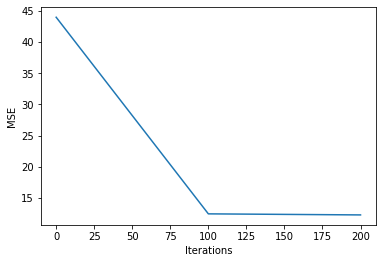

In [38]:
num_iter = 300
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations
plt.figure()
plt.plot(np.arange(0, num_iter, 100), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [39]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[ 7.464e+01, -1.452e+00, -4.572e+00, ..., -3.476e-01,  1.286e+00,
        -8.629e-01],
       [ 9.875e+01,  1.075e+00,  2.631e+00, ...,  1.364e+00, -1.884e+00,
        -2.894e-01],
       [ 4.931e+01, -2.702e-01, -1.024e+00, ...,  1.900e-01,  2.485e-02,
        -3.740e-01],
       ...,
       [ 3.870e+01, -3.000e-01, -1.058e+00, ...,  9.560e-02,  1.247e-01,
        -3.186e-01],
       [ 3.715e+01, -4.285e-01, -1.423e+00, ...,  6.246e-03,  2.878e-01,
        -3.457e-01],
       [ 7.212e+01, -1.031e+00, -3.339e+00, ..., -1.090e-01,  7.969e-01,
        -7.278e-01]])

changing hyper-parameters to study model performance

In [40]:
n_latent_factors = 4

user_ratings = train_set.values

# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [41]:
latent_item_features

array([[5.537e-01, 5.948e-01, 3.543e-01, 7.109e-01],
       [1.020e-02, 1.762e-01, 8.604e-02, 5.594e-01],
       [6.402e-01, 5.670e-02, 5.788e-01, 6.059e-01],
       [9.723e-01, 9.026e-01, 2.795e-01, 4.220e-01],
       [7.656e-01, 5.220e-01, 9.303e-01, 3.048e-01],
       [4.881e-01, 3.907e-01, 8.645e-01, 3.789e-01],
       [1.601e-01, 3.527e-01, 8.455e-01, 9.251e-01],
       [8.355e-01, 8.277e-02, 6.425e-01, 1.216e-01],
       [2.692e-01, 5.324e-01, 5.917e-01, 9.720e-01],
       [7.773e-01, 5.694e-01, 2.645e-01, 9.468e-02],
       [4.888e-01, 4.734e-01, 4.640e-01, 1.129e-02],
       [5.816e-01, 3.747e-01, 4.995e-01, 3.156e-01],
       [1.999e-01, 5.193e-01, 4.494e-01, 8.195e-01],
       [2.858e-01, 1.528e-01, 2.191e-01, 3.822e-01],
       [3.518e-01, 2.468e-01, 8.866e-02, 5.203e-01],
       [3.865e-02, 5.780e-01, 4.577e-01, 2.086e-01],
       [3.348e-01, 2.682e-01, 4.306e-01, 1.982e-01],
       [5.735e-01, 1.695e-01, 3.533e-01, 5.957e-01],
       [3.300e-01, 8.980e-01, 3.798e-01, 9.150

In [42]:
latent_user_preferences

array([[0.013, 0.263, 0.112, 0.537],
       [0.303, 0.593, 0.575, 0.442],
       [0.464, 0.194, 0.947, 0.589],
       ...,
       [0.806, 0.498, 0.509, 0.386],
       [0.571, 0.802, 0.945, 0.292],
       [0.928, 0.222, 0.488, 0.644]])

In [43]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)

In [44]:
def train(user_id, item_id, rating, alpha=0.0002):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 100) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

Iteration 0/500:	MSE=29.553436
Iteration 100/500:	MSE=11.282495
Iteration 200/500:	MSE=11.192338
Iteration 300/500:	MSE=11.297725
Iteration 400/500:	MSE=12.218983


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in square


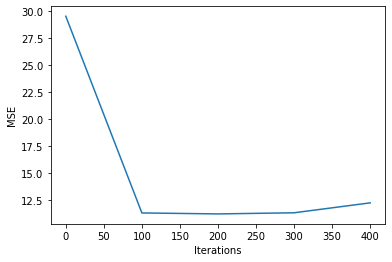

In [45]:
num_iter = 500
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations
plt.figure()
plt.plot(np.arange(0, num_iter, 100), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [46]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

# Movie dataset

In [ ]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

In [ ]:
df_user = pd.read_excel('/content/drive/MyDrive/data science /movies_latent_factors.xlsx', sheet_name='Users')

In [ ]:
df_movieID = pd.read_excel('/content/drive/MyDrive/data science /movies_latent_factors.xlsx', sheet_name='Items')

In [ ]:
print("Column headings:")
print(df.columns)

Column headings:
Index(['User', 'Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5',
       'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11',
       'Factor12', 'Factor13', 'Factor14', 'Factor15'],
      dtype='object')


In [ ]:
df_user.head()

,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
1,156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
2,5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
3,174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4,4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669


In [ ]:
df_movieID.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


Merging datasets modelling

In [ ]:
from sklearn.svm import SVC

np.set_printoptions(precision=3)

Now load the data

In [ ]:
df_user['key'] = 0
df_user['user_id'] = range(df_user.shape[0])
df_movieID['key'] = 0
df_movieID['item_id'] = range(df_movieID.shape[0])

In [ ]:
merged_df = pd.merge(df_user, df_movieID, left_index=True, on="key")
merged_df.drop(labels='key', axis=1, inplace=True)  # drop the "key" column


In [ ]:
merged_df.head()

,User,Factor1_x,Factor2_x,Factor3_x,Factor4_x,Factor5_x,Factor6_x,Factor7_x,Factor8_x,Factor9_x,Factor10_x,Factor11_x,Factor12_x,Factor13_x,Factor14_x,Factor15_x,user_id,Movie ID,Title,Factor1_y,Factor2_y,Factor3_y,Factor4_y,Factor5_y,Factor6_y,Factor7_y,Factor8_y,Factor9_y,Factor10_y,Factor11_y,Factor12_y,Factor13_y,Factor14_y,Factor15_y,movie_id,item_id
0,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125,0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806,0,0
1,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125,0,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993,1,1
2,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125,0,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092,2,2
3,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125,0,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191,3,3
4,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125,0,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566,4,4


In [ ]:
merged_df[["item_id", "user_id"]]

,item_id,user_id
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
95,95,24
96,96,24
97,97,24
98,98,24


In [ ]:
merged_df["Rating"]  = list(map(lambda ids: df_user.values[ids[1]][ids[2]], 
                          merged_df[["item_id", "user_id"]].itertuples()))

In [ ]:
train = merged_df.dropna()

In [ ]:
test = merged_df[merged_df.isnull().any(axis=1)]

### Questions

In the movies dataset, what's the rating that user 12215 has given to joke 33?
Give your answer with two decimal values (e.g., 0.13).

In [ ]:
dataset.iloc[12215 , 33]

8.4

In the movies dataset, what's the loading (i.e., value) of Factor6 for the movie with ID=854?

In [ ]:
df_movieID.loc[df_movieID['Movie ID'] == 854]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,key,movie_id
68,854,The Mask (1994),2.263142,-0.067761,-0.205463,0.06888,-0.18909,2.078554,2.444922,-0.075971,-0.674767,-0.19856,1.64138,-0.839276,-0.517086,-1.058431,-0.931746,0,68


In the movies dataset, which of the following IDs corresponds to the movie with the lowest loading of factor 8?

In [ ]:
print(df_movieID['Factor8'].min())

-1.6863437494636568


In [ ]:
minRating = df_movieID[df_movieID.Factor8 == df_movieID.Factor8.min()]

In [ ]:
minRating.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,key,movie_id
30,272,Batman Begins (2005),-0.920371,-0.694112,0.399493,-0.613952,-1.443527,-0.688206,0.758949,-1.686344,0.179139,-1.098354,-1.388191,-0.174228,1.79318,0.448899,0.484224,0,30
